In [1]:
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, Subset
import matplotlib.pyplot as plt

loaded_data = joblib.load("train_data.pkl")

targets, data, ids = loaded_data

# 打印某个人的具体信息

for i in tqdm(range(277)):
    if ids[i] == "44a41bba1ee7":
        print(f"Target: {targets[i]}")
        print(f"{data[i]}")
        print(type(targets[i]))
        print(type(data[i]))

100%|██████████| 277/277 [00:00<00:00, 15850.67it/s]

Target: [(6228, 12324), (22044, 28248), (59016, 65064), (78024, 82068), (95400, 99444), (109956, 114480), (126780, 132972), (144984, 151944), (191376, 199020), (211716, 217476), (243036, 251184)]
           anglez      enmo      step
0       26.234375  0.142456       0.0
1       25.828125  0.142456       1.0
2       25.687500  0.140015       2.0
3       26.640625  0.141968       3.0
4       26.140625  0.154053       4.0
...           ...       ...       ...
328135  -2.517578  0.027496  328135.0
328136 -10.000000  0.016602  328136.0
328137 -12.046875  0.015198  328137.0
328138 -12.585938  0.013901  328138.0
328139 -16.937500  0.013000  328139.0

[328140 rows x 3 columns]
<class 'list'>
<class 'pandas.core.frame.DataFrame'>


In [2]:
class CFG:
    window_overlap = 60
    window_size = 120
    train_ratio = 0.8
    batch_size = 32
    input_dim = 2
    embed_dim = 32
    num_classes = 3 
    num_layers = 4
    nhead = 4
    dim_feedforward = 64
    learning_rate = 1e-3
    epochs = 10
    steps = 20
    dropout = 0.4

In [3]:
# 生成放入模型的数据，假设使用30分钟作为一个窗口，那么需要找的为形状（360，2）的矩阵

train_events = pd.read_csv("./train_events.csv")
num_person = len(train_events["series_id"].unique())
print("The number of total persons is:", num_person)

# 用来存储模型的输入与标签
X = []
y = []

for i in tqdm(range(20)):

    df = data[i]
    pair_list = targets[i]
    sleep_id = ids[i]

    # 先提取出开始睡觉和结束睡觉的时间
    onset_steps = []
    wakeup_steps = []
    for j in range(len(pair_list)):
        onset_steps.append(pair_list[j][0])
        wakeup_steps.append(pair_list[j][1])
    # print("length of onset list:", len(onset_steps))
    # print("length of wakeup list:", len(wakeup_steps))
    # print(onset_steps)
    # print(wakeup_steps)

    # 中间没有明确时间点的区间全部都不要
    empty_spaces = []
    events = train_events[train_events["series_id"] == sleep_id]
    last_events = 0
    mark = 0 
    for (idx, row) in events.iterrows():
        if np.isnan(row["step"]):
            mark = 1
        else:
            if row["step"] > last_events and mark == 0:
                last_events = row["step"]
            elif row["step"] > last_events and mark == 1:
                empty_spaces.append((int(last_events + 720), int(row["step"] - 720)))
                last_events = row["step"]
                mark = 0

    # print(empty_spaces)

    # 为训练数据设置label，如果区间中没有任何事件，标签为0，如果有开始睡觉事件，标签为1，如果有结束睡觉事件，标签为2
    labels = []
    for j in range(0, len(df), CFG.window_overlap):
        start = j
        if j + CFG.window_size >= len(df):
            break
        else:
            end = j + CFG.window_size

        flag = 0
        for k in empty_spaces:
            if (k[0] <= start <= k[1]) or (k[0] <= end <= k[1]):
                flag = 1
                break
            else:
                continue

        chunk = df.iloc[start:end][["anglez", "enmo"]]
        chunk = chunk.to_numpy()

        if flag == 1:
            label = 3
        elif any(start <= num <= end for num in wakeup_steps):
            label = 2
        elif any(start <= num <= end for num in onset_steps):
            label = 1
        else:
            label = 0
        labels.append(label)

        if label != 3:
            X.append(chunk)
            y.append(label)

    element_counts = Counter(labels)

    for element, count in element_counts.items():
        print(f'Element {element} occurs {count} times')

print(len(X), len(y))

The number of total persons is: 277


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:03<00:58,  3.10s/it]

Element 0 occurs 5110 times
Element 1 occurs 43 times
Element 2 occurs 42 times
Element 3 occurs 1301 times


 10%|█         | 2/20 [00:09<01:34,  5.23s/it]

Element 0 occurs 9588 times
Element 1 occurs 19 times
Element 2 occurs 18 times
Element 3 occurs 2442 times


 15%|█▌        | 3/20 [00:13<01:16,  4.47s/it]

Element 0 occurs 5034 times
Element 1 occurs 39 times
Element 2 occurs 40 times
Element 3 occurs 1506 times


 20%|██        | 4/20 [00:18<01:14,  4.67s/it]

Element 0 occurs 8404 times
Element 3 occurs 2129 times
Element 1 occurs 44 times
Element 2 occurs 47 times


 25%|██▌       | 5/20 [00:21<01:02,  4.15s/it]

Element 0 occurs 6324 times
Element 3 occurs 321 times
Element 1 occurs 16 times
Element 2 occurs 18 times


 30%|███       | 6/20 [00:24<00:52,  3.75s/it]

Element 0 occurs 4328 times
Element 1 occurs 6 times
Element 2 occurs 7 times
Element 3 occurs 3031 times


 35%|███▌      | 7/20 [00:29<00:54,  4.20s/it]

Element 0 occurs 8421 times
Element 1 occurs 33 times
Element 2 occurs 29 times
Element 3 occurs 4493 times


 40%|████      | 8/20 [00:32<00:45,  3.78s/it]

Element 0 occurs 7223 times
Element 1 occurs 56 times
Element 2 occurs 57 times


 45%|████▌     | 9/20 [00:34<00:34,  3.12s/it]

Element 0 occurs 4214 times
Element 1 occurs 32 times
Element 2 occurs 33 times


 50%|█████     | 10/20 [00:36<00:29,  2.91s/it]

Element 0 occurs 3971 times
Element 1 occurs 12 times
Element 2 occurs 13 times
Element 3 occurs 2173 times


 55%|█████▌    | 11/20 [00:40<00:29,  3.28s/it]

Element 0 occurs 9682 times
Element 1 occurs 70 times
Element 2 occurs 67 times
Element 3 occurs 265 times


 60%|██████    | 12/20 [00:43<00:24,  3.09s/it]

Element 0 occurs 6320 times
Element 1 occurs 45 times
Element 2 occurs 44 times


 65%|██████▌   | 13/20 [00:46<00:20,  2.98s/it]

Element 0 occurs 5466 times
Element 1 occurs 42 times
Element 2 occurs 47 times
Element 3 occurs 1190 times


 70%|███████   | 14/20 [00:48<00:17,  2.92s/it]

Element 0 occurs 4987 times
Element 1 occurs 46 times
Element 2 occurs 45 times
Element 3 occurs 1772 times


 75%|███████▌  | 15/20 [00:52<00:15,  3.19s/it]

Element 0 occurs 8394 times
Element 1 occurs 64 times
Element 2 occurs 67 times
Element 3 occurs 1022 times


 80%|████████  | 16/20 [00:55<00:11,  2.96s/it]

Element 0 occurs 5955 times
Element 1 occurs 47 times
Element 2 occurs 44 times


 85%|████████▌ | 17/20 [00:58<00:09,  3.10s/it]

Element 0 occurs 5575 times
Element 1 occurs 48 times
Element 2 occurs 46 times
Element 3 occurs 2927 times


 90%|█████████ | 18/20 [01:00<00:05,  2.69s/it]

Element 0 occurs 4444 times


 95%|█████████▌| 19/20 [01:02<00:02,  2.66s/it]

Element 0 occurs 6258 times
Element 1 occurs 7 times
Element 2 occurs 7 times
Element 3 occurs 443 times


100%|██████████| 20/20 [01:05<00:00,  3.28s/it]

Element 0 occurs 6744 times
Element 1 occurs 51 times
Element 2 occurs 52 times
127885 127885


In [4]:
X_noevent = []
y_noevent = []
X_onset = []
y_onset = []
X_wakeup = []
y_wakeup = []

for i in tqdm(range(len(X))):
    xi = X[i]
    yi = y[i]
    if yi == 0:
        X_noevent.append(xi)
        y_noevent.append(yi)
    elif yi == 1:
        X_onset.append(xi)
        y_onset.append(yi)
    elif yi == 2:
        X_wakeup.append(xi)
        y_wakeup.append(yi)

print(len(X_noevent), len(X_onset), len(X_wakeup))

X_noevent = X_noevent[:10400]
y_noevent = y_noevent[:10400]
X = X_noevent + X_onset + X_wakeup
y = y_noevent + y_onset + y_wakeup

print(len(X), len(y))

100%|██████████| 127885/127885 [00:00<00:00, 1325918.92it/s]

126442 720 723
11843 11843


In [5]:
class MyDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        inp = self.inputs[index]
        output = self.outputs[index]

        input_tensor = torch.tensor(inp, dtype=torch.float32)
        output_tensor = torch.tensor(output, dtype=torch.long)

        return input_tensor, output_tensor


dataset = MyDataset(X, y)
print(len(dataset))

train_size = int(CFG.train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=True)
print(len(train_loader), len(test_loader))

11843
297 75


In [6]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        num_classes=3,
        num_layers=8,
        nhead=4,
        dim_feedforward=64,
        dropout=0.4
    ):

        super(TransformerModel, self).__init__()

        self.conv1d = nn.Conv1d(
            in_channels=input_dim, 
            out_channels=embed_dim, 
            kernel_size=3, 
            padding=1
        )
        self.embed_layer = nn.Linear(embed_dim, embed_dim)
        self.layernorm = nn.LayerNorm(embed_dim)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout
            ),
            num_layers=num_layers
        )

        self.classification = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = x.permute(0, 2, 1)

        x = self.embed_layer(x)
        x = self.layernorm(x)
        x = self.encoder(x.permute(1, 0, 2))
        x = x[-1]
        x = self.classification(x)
        return x


model = TransformerModel(input_dim=2, embed_dim=32)
input_data = torch.rand(3, 360, 2)
output = model(input_data)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
print(output.shape)

TransformerModel(
  (conv1d): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (embed_layer): Linear(in_features=32, out_features=32, bias=True)
  (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (classification): Linear(in_features=32, out_features=3, bias=True)
)
Total 

In [7]:
model = TransformerModel(
    input_dim=CFG.input_dim,
    embed_dim=CFG.embed_dim,
    num_classes=CFG.num_classes,
    num_layers=CFG.num_layers,
    nhead=CFG.nhead,
    dim_feedforward=CFG.dim_feedforward,
    dropout=CFG.dropout
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)
device = "cuda" if torch.cuda.is_available() else "cpu"

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 35619


In [8]:
model.train()
train_losses = []
train_step_losses = []
test_losses = []
test_step_losses = []

for epoch in range(1, CFG.epochs + 1):
    train_loss = 0.0
    test_loss = 0.0
    train_step_loss = 0.0
    test_step_loss = 0.0

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)
        output = model(data)

        loss = criterion(output, target)
        train_loss += loss.item()
        train_step_loss += loss.item()

        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % CFG.steps == 0:
            train_step_loss /= CFG.steps
            train_step_losses.append(train_step_loss)
            print(f"Step: {(batch_idx + 1) * CFG.steps}, Train Loss These Steps: {train_step_loss}")
            train_step_loss = 0.0

    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
            data = data.to(device)
            target = target.to(device)
            output = model(data)

            loss = criterion(output, target)
            test_loss += loss.item()
            test_step_loss += loss.item()

            if (batch_idx + 1) % CFG.steps == 0:
                test_step_loss /= CFG.steps
                test_step_losses.append(test_step_loss)
                print(f"Step: {(batch_idx + 1) * CFG.steps}, Test Loss These Steps: {test_step_loss}")
                test_step_loss = 0.0

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}")

  7%|▋         | 21/297 [00:03<00:50,  5.47it/s]

Step: 400, Train Loss These Steps: 0.572431480884552


 14%|█▍        | 41/297 [00:07<00:44,  5.79it/s]

Step: 800, Train Loss These Steps: 0.5114062041044235


 21%|██        | 61/297 [00:10<00:38,  6.11it/s]

Step: 1200, Train Loss These Steps: 0.5209275610744953


 27%|██▋       | 80/297 [00:14<00:46,  4.69it/s]

Step: 1600, Train Loss These Steps: 0.4677841916680336


 34%|███▍      | 101/297 [00:19<00:39,  5.00it/s]

Step: 2000, Train Loss These Steps: 0.4777944523841143


 41%|████      | 121/297 [00:23<00:34,  5.17it/s]

Step: 2400, Train Loss These Steps: 0.4348697796463966


 47%|████▋     | 140/297 [00:27<00:34,  4.53it/s]

Step: 2800, Train Loss These Steps: 0.4744305867701769


 54%|█████▍    | 160/297 [00:31<00:34,  3.96it/s]

Step: 3200, Train Loss These Steps: 0.4772317796945572


 61%|██████    | 180/297 [00:36<00:24,  4.80it/s]

Step: 3600, Train Loss These Steps: 0.4532072052359581


 67%|██████▋   | 200/297 [00:40<00:19,  4.94it/s]

Step: 4000, Train Loss These Steps: 0.45161706022918224


 74%|███████▍  | 221/297 [00:45<00:16,  4.66it/s]

Step: 4400, Train Loss These Steps: 0.4403097085654736


 81%|████████  | 241/297 [00:50<00:12,  4.66it/s]

Step: 4800, Train Loss These Steps: 0.42392735853791236


 88%|████████▊ | 261/297 [00:54<00:06,  5.16it/s]

Step: 5200, Train Loss These Steps: 0.41262714341282847


 95%|█████████▍| 281/297 [00:58<00:02,  5.94it/s]

Step: 5600, Train Loss These Steps: 0.4618926465511322


 29%|██▉       | 22/75 [00:02<00:04, 10.96it/s]

Step: 400, Test Loss These Steps: 0.41394266560673715


 56%|█████▌    | 42/75 [00:03<00:03, 10.74it/s]

Step: 800, Test Loss These Steps: 0.4617151439189911


 83%|████████▎ | 62/75 [00:05<00:01, 11.21it/s]

Step: 1200, Test Loss These Steps: 0.3801021806895733


100%|██████████| 75/75 [00:06<00:00, 11.11it/s]


Epoch: 1, Train Loss: 0.4672492014789822, Test Loss: 0.4225305636723836


  7%|▋         | 21/297 [00:03<00:43,  6.30it/s]

Step: 400, Train Loss These Steps: 0.4063717655837536


 14%|█▍        | 41/297 [00:06<00:42,  6.01it/s]

Step: 800, Train Loss These Steps: 0.42134690657258034


 21%|██        | 61/297 [00:09<00:38,  6.14it/s]

Step: 1200, Train Loss These Steps: 0.42381361201405526


 27%|██▋       | 81/297 [00:13<00:37,  5.71it/s]

Step: 1600, Train Loss These Steps: 0.45271685644984244


 34%|███▍      | 101/297 [00:16<00:30,  6.33it/s]

Step: 2000, Train Loss These Steps: 0.3957710050046444


 41%|████      | 121/297 [00:19<00:26,  6.54it/s]

Step: 2400, Train Loss These Steps: 0.4304057344794273


 47%|████▋     | 141/297 [00:22<00:23,  6.55it/s]

Step: 2800, Train Loss These Steps: 0.4723541371524334


 54%|█████▍    | 161/297 [00:25<00:20,  6.58it/s]

Step: 3200, Train Loss These Steps: 0.4179190367460251


 61%|██████    | 181/297 [00:28<00:17,  6.51it/s]

Step: 3600, Train Loss These Steps: 0.40640774741768837


 68%|██████▊   | 201/297 [00:32<00:14,  6.49it/s]

Step: 4000, Train Loss These Steps: 0.42109174132347105


 74%|███████▍  | 221/297 [00:35<00:12,  5.92it/s]

Step: 4400, Train Loss These Steps: 0.37144372761249544


 81%|████████  | 241/297 [00:38<00:08,  6.56it/s]

Step: 4800, Train Loss These Steps: 0.48076922819018364


 88%|████████▊ | 261/297 [00:41<00:05,  6.45it/s]

Step: 5200, Train Loss These Steps: 0.3913342490792274


 95%|█████████▍| 281/297 [00:44<00:02,  6.42it/s]

Step: 5600, Train Loss These Steps: 0.43531078919768335


 29%|██▉       | 22/75 [00:01<00:04, 11.57it/s]

Step: 400, Test Loss These Steps: 0.39150082394480706


 56%|█████▌    | 42/75 [00:03<00:03, 10.46it/s]

Step: 800, Test Loss These Steps: 0.46846507042646407


 81%|████████▏ | 61/75 [00:05<00:01,  7.52it/s]

Step: 1200, Test Loss These Steps: 0.37825392484664916


100%|██████████| 75/75 [00:07<00:00,  9.88it/s]


Epoch: 2, Train Loss: 0.4199044508514581, Test Loss: 0.3918850537141164


  7%|▋         | 20/297 [00:04<01:04,  4.27it/s]

Step: 400, Train Loss These Steps: 0.4067959636449814


 14%|█▍        | 41/297 [00:08<00:39,  6.41it/s]

Step: 800, Train Loss These Steps: 0.40061140060424805


 21%|██        | 61/297 [00:11<00:36,  6.53it/s]

Step: 1200, Train Loss These Steps: 0.44780656695365906


 27%|██▋       | 81/297 [00:14<00:33,  6.48it/s]

Step: 1600, Train Loss These Steps: 0.40144520848989484


 34%|███▍      | 101/297 [00:17<00:30,  6.48it/s]

Step: 2000, Train Loss These Steps: 0.3902848720550537


 41%|████      | 121/297 [00:20<00:27,  6.46it/s]

Step: 2400, Train Loss These Steps: 0.4358389999717474


 47%|████▋     | 141/297 [00:23<00:24,  6.43it/s]

Step: 2800, Train Loss These Steps: 0.40080812722444537


 54%|█████▍    | 161/297 [00:26<00:20,  6.59it/s]

Step: 3200, Train Loss These Steps: 0.40112986154854297


 61%|██████    | 181/297 [00:29<00:17,  6.57it/s]

Step: 3600, Train Loss These Steps: 0.4072181835770607


 68%|██████▊   | 201/297 [00:32<00:15,  6.36it/s]

Step: 4000, Train Loss These Steps: 0.4411227196455002


 74%|███████▍  | 221/297 [00:36<00:12,  6.31it/s]

Step: 4400, Train Loss These Steps: 0.41837610229849814


 81%|████████  | 241/297 [00:39<00:09,  6.16it/s]

Step: 4800, Train Loss These Steps: 0.4052812308073044


 88%|████████▊ | 261/297 [00:42<00:05,  6.34it/s]

Step: 5200, Train Loss These Steps: 0.35607222430408003


 95%|█████████▍| 281/297 [00:46<00:02,  5.42it/s]

Step: 5600, Train Loss These Steps: 0.3430430941283703


 29%|██▉       | 22/75 [00:02<00:04, 11.08it/s]

Step: 400, Test Loss These Steps: 0.3905831463634968


 56%|█████▌    | 42/75 [00:03<00:02, 11.19it/s]

Step: 800, Test Loss These Steps: 0.4124972641468048


 83%|████████▎ | 62/75 [00:05<00:01, 11.62it/s]

Step: 1200, Test Loss These Steps: 0.3852140009403229


100%|██████████| 75/75 [00:06<00:00, 11.39it/s]


Epoch: 3, Train Loss: 0.4040083819216349, Test Loss: 0.3951233665148417


  7%|▋         | 21/297 [00:03<00:42,  6.47it/s]

Step: 400, Train Loss These Steps: 0.3319700077176094


 14%|█▍        | 41/297 [00:06<00:37,  6.80it/s]

Step: 800, Train Loss These Steps: 0.3998626612126827


 21%|██        | 61/297 [00:09<00:35,  6.68it/s]

Step: 1200, Train Loss These Steps: 0.3634742867201567


 27%|██▋       | 81/297 [00:12<00:32,  6.61it/s]

Step: 1600, Train Loss These Steps: 0.4067454680800438


 34%|███▍      | 101/297 [00:15<00:29,  6.66it/s]

Step: 2000, Train Loss These Steps: 0.36980265006422997


 41%|████      | 121/297 [00:18<00:26,  6.68it/s]

Step: 2400, Train Loss These Steps: 0.3911768466234207


 47%|████▋     | 141/297 [00:21<00:23,  6.68it/s]

Step: 2800, Train Loss These Steps: 0.4162056803703308


 54%|█████▍    | 161/297 [00:24<00:20,  6.51it/s]

Step: 3200, Train Loss These Steps: 0.3668757200241089


 61%|██████    | 181/297 [00:27<00:17,  6.47it/s]

Step: 3600, Train Loss These Steps: 0.3930726386606693


 68%|██████▊   | 201/297 [00:30<00:14,  6.58it/s]

Step: 4000, Train Loss These Steps: 0.3961176238954067


 74%|███████▍  | 221/297 [00:33<00:11,  6.39it/s]

Step: 4400, Train Loss These Steps: 0.4352787122130394


 81%|████████  | 241/297 [00:36<00:08,  6.69it/s]

Step: 4800, Train Loss These Steps: 0.388503922522068


 88%|████████▊ | 261/297 [00:39<00:05,  6.71it/s]

Step: 5200, Train Loss These Steps: 0.45834378376603124


 95%|█████████▍| 281/297 [00:43<00:02,  6.49it/s]

Step: 5600, Train Loss These Steps: 0.44535871520638465


 29%|██▉       | 22/75 [00:01<00:04, 11.54it/s]

Step: 400, Test Loss These Steps: 0.418650721013546


 56%|█████▌    | 42/75 [00:03<00:02, 11.91it/s]

Step: 800, Test Loss These Steps: 0.3649491690099239


 83%|████████▎ | 62/75 [00:05<00:01, 11.80it/s]

Step: 1200, Test Loss These Steps: 0.36136402785778043


100%|██████████| 75/75 [00:06<00:00, 11.50it/s]


Epoch: 4, Train Loss: 0.3955307035183264, Test Loss: 0.3715405684709549


  7%|▋         | 21/297 [00:03<00:44,  6.25it/s]

Step: 400, Train Loss These Steps: 0.4616149052977562


 14%|█▍        | 41/297 [00:06<00:39,  6.56it/s]

Step: 800, Train Loss These Steps: 0.35147133767604827


 21%|██        | 61/297 [00:09<00:36,  6.55it/s]

Step: 1200, Train Loss These Steps: 0.40361363887786866


 27%|██▋       | 81/297 [00:12<00:32,  6.55it/s]

Step: 1600, Train Loss These Steps: 0.40625069439411166


 34%|███▍      | 101/297 [00:15<00:29,  6.62it/s]

Step: 2000, Train Loss These Steps: 0.4168598845601082


 41%|████      | 121/297 [00:18<00:26,  6.52it/s]

Step: 2400, Train Loss These Steps: 0.3517812371253967


 47%|████▋     | 141/297 [00:21<00:23,  6.70it/s]

Step: 2800, Train Loss These Steps: 0.31323934961110356


 54%|█████▍    | 161/297 [00:24<00:21,  6.39it/s]

Step: 3200, Train Loss These Steps: 0.35507608130574225


 61%|██████    | 181/297 [00:27<00:17,  6.56it/s]

Step: 3600, Train Loss These Steps: 0.4158675029873848


 68%|██████▊   | 201/297 [00:30<00:14,  6.51it/s]

Step: 4000, Train Loss These Steps: 0.3739730939269066


 74%|███████▍  | 221/297 [00:33<00:11,  6.52it/s]

Step: 4400, Train Loss These Steps: 0.3188769266009331


 81%|████████  | 241/297 [00:36<00:08,  6.58it/s]

Step: 4800, Train Loss These Steps: 0.3821527734398842


 88%|████████▊ | 261/297 [00:39<00:05,  6.59it/s]

Step: 5200, Train Loss These Steps: 0.3792323634028435


 95%|█████████▍| 281/297 [00:43<00:02,  6.55it/s]

Step: 5600, Train Loss These Steps: 0.4177545793354511


 29%|██▉       | 22/75 [00:01<00:04, 11.53it/s]

Step: 400, Test Loss These Steps: 0.4507762514054775


 56%|█████▌    | 42/75 [00:03<00:02, 11.38it/s]

Step: 800, Test Loss These Steps: 0.44111638367176054


 83%|████████▎ | 62/75 [00:05<00:01, 11.09it/s]

Step: 1200, Test Loss These Steps: 0.4514371655881405


100%|██████████| 75/75 [00:06<00:00, 11.58it/s]


Epoch: 5, Train Loss: 0.38193659575950817, Test Loss: 0.4445622397462527


  7%|▋         | 21/297 [00:03<00:44,  6.24it/s]

Step: 400, Train Loss These Steps: 0.4430909179151058


 14%|█▍        | 41/297 [00:06<00:38,  6.71it/s]

Step: 800, Train Loss These Steps: 0.3894756279885769


 21%|██        | 61/297 [00:09<00:36,  6.52it/s]

Step: 1200, Train Loss These Steps: 0.40801951140165327


 27%|██▋       | 81/297 [00:12<00:33,  6.52it/s]

Step: 1600, Train Loss These Steps: 0.3833208605647087


 34%|███▍      | 101/297 [00:15<00:31,  6.32it/s]

Step: 2000, Train Loss These Steps: 0.39391760528087616


 41%|████      | 121/297 [00:18<00:26,  6.52it/s]

Step: 2400, Train Loss These Steps: 0.3534680657088757


 47%|████▋     | 141/297 [00:21<00:25,  6.23it/s]

Step: 2800, Train Loss These Steps: 0.4222244266420603


 54%|█████▍    | 161/297 [00:24<00:20,  6.48it/s]

Step: 3200, Train Loss These Steps: 0.43173191100358965


 61%|██████    | 181/297 [00:27<00:17,  6.65it/s]

Step: 3600, Train Loss These Steps: 0.35041164308786393


 68%|██████▊   | 201/297 [00:30<00:14,  6.61it/s]

Step: 4000, Train Loss These Steps: 0.3642283730208874


 74%|███████▍  | 221/297 [00:33<00:11,  6.84it/s]

Step: 4400, Train Loss These Steps: 0.32637484818696977


 81%|████████  | 241/297 [00:37<00:08,  6.48it/s]

Step: 4800, Train Loss These Steps: 0.37166693396866324


 88%|████████▊ | 261/297 [00:40<00:05,  6.68it/s]

Step: 5200, Train Loss These Steps: 0.384028697758913


 95%|█████████▍| 281/297 [00:43<00:02,  6.69it/s]

Step: 5600, Train Loss These Steps: 0.30348477251827716


 29%|██▉       | 22/75 [00:01<00:04, 11.25it/s]

Step: 400, Test Loss These Steps: 0.37050239071249963


 56%|█████▌    | 42/75 [00:03<00:02, 11.49it/s]

Step: 800, Test Loss These Steps: 0.31655099987983704


 83%|████████▎ | 62/75 [00:05<00:01, 11.43it/s]

Step: 1200, Test Loss These Steps: 0.4157898150384426


100%|██████████| 75/75 [00:06<00:00, 11.50it/s]


Epoch: 6, Train Loss: 0.3847880825300008, Test Loss: 0.36345490942398706


  7%|▋         | 21/297 [00:03<00:41,  6.62it/s]

Step: 400, Train Loss These Steps: 0.4048031322658062


 14%|█▍        | 41/297 [00:06<00:39,  6.42it/s]

Step: 800, Train Loss These Steps: 0.39774760603904724


 21%|██        | 61/297 [00:09<00:35,  6.70it/s]

Step: 1200, Train Loss These Steps: 0.3850071094930172


 27%|██▋       | 81/297 [00:12<00:33,  6.49it/s]

Step: 1600, Train Loss These Steps: 0.35536795407533645


 34%|███▍      | 101/297 [00:15<00:31,  6.28it/s]

Step: 2000, Train Loss These Steps: 0.4107300668954849


 41%|████      | 121/297 [00:18<00:26,  6.62it/s]

Step: 2400, Train Loss These Steps: 0.382395102083683


 47%|████▋     | 141/297 [00:21<00:23,  6.60it/s]

Step: 2800, Train Loss These Steps: 0.3501166194677353


 54%|█████▍    | 161/297 [00:24<00:20,  6.63it/s]

Step: 3200, Train Loss These Steps: 0.3673455573618412


 61%|██████    | 181/297 [00:27<00:18,  6.17it/s]

Step: 3600, Train Loss These Steps: 0.35611473992466924


 68%|██████▊   | 201/297 [00:30<00:14,  6.50it/s]

Step: 4000, Train Loss These Steps: 0.35312254503369334


 74%|███████▍  | 221/297 [00:33<00:11,  6.39it/s]

Step: 4400, Train Loss These Steps: 0.3697387740015984


 81%|████████  | 241/297 [00:37<00:08,  6.42it/s]

Step: 4800, Train Loss These Steps: 0.31814235597848894


 88%|████████▊ | 261/297 [00:40<00:05,  6.45it/s]

Step: 5200, Train Loss These Steps: 0.399272583425045


 95%|█████████▍| 281/297 [00:43<00:02,  6.32it/s]

Step: 5600, Train Loss These Steps: 0.3899524390697479


 29%|██▉       | 22/75 [00:01<00:04, 11.27it/s]

Step: 400, Test Loss These Steps: 0.39930031821131706


 56%|█████▌    | 42/75 [00:03<00:02, 11.68it/s]

Step: 800, Test Loss These Steps: 0.3229047317057848


 83%|████████▎ | 62/75 [00:05<00:01, 11.68it/s]

Step: 1200, Test Loss These Steps: 0.34473240152001383


100%|██████████| 75/75 [00:06<00:00, 11.55it/s]


Epoch: 7, Train Loss: 0.3701691365854106, Test Loss: 0.3545598880449931


  7%|▋         | 21/297 [00:03<00:42,  6.49it/s]

Step: 400, Train Loss These Steps: 0.37459483854472636


 14%|█▍        | 41/297 [00:06<00:38,  6.63it/s]

Step: 800, Train Loss These Steps: 0.38882586136460306


 21%|██        | 61/297 [00:09<00:36,  6.39it/s]

Step: 1200, Train Loss These Steps: 0.37734069377183915


 27%|██▋       | 81/297 [00:12<00:32,  6.55it/s]

Step: 1600, Train Loss These Steps: 0.3427018202841282


 34%|███▍      | 101/297 [00:15<00:30,  6.49it/s]

Step: 2000, Train Loss These Steps: 0.3355752401053905


 41%|████      | 121/297 [00:18<00:27,  6.33it/s]

Step: 2400, Train Loss These Steps: 0.3350317761301994


 47%|████▋     | 141/297 [00:21<00:23,  6.71it/s]

Step: 2800, Train Loss These Steps: 0.37551716044545175


 54%|█████▍    | 161/297 [00:24<00:20,  6.53it/s]

Step: 3200, Train Loss These Steps: 0.32468853890895844


 61%|██████    | 181/297 [00:27<00:17,  6.45it/s]

Step: 3600, Train Loss These Steps: 0.34602279774844646


 68%|██████▊   | 201/297 [00:31<00:15,  6.27it/s]

Step: 4000, Train Loss These Steps: 0.37391432747244835


 74%|███████▍  | 221/297 [00:34<00:11,  6.62it/s]

Step: 4400, Train Loss These Steps: 0.4089531660079956


 81%|████████  | 241/297 [00:37<00:08,  6.48it/s]

Step: 4800, Train Loss These Steps: 0.37933608889579773


 88%|████████▊ | 261/297 [00:40<00:05,  6.42it/s]

Step: 5200, Train Loss These Steps: 0.3465077646076679


 95%|█████████▍| 281/297 [00:43<00:02,  6.46it/s]

Step: 5600, Train Loss These Steps: 0.3593220770359039


 29%|██▉       | 22/75 [00:01<00:04, 11.19it/s]

Step: 400, Test Loss These Steps: 0.3340485952794552


 56%|█████▌    | 42/75 [00:03<00:02, 11.31it/s]

Step: 800, Test Loss These Steps: 0.3581142157316208


 83%|████████▎ | 62/75 [00:05<00:01, 11.60it/s]

Step: 1200, Test Loss These Steps: 0.3632200948894024


100%|██████████| 75/75 [00:06<00:00, 11.52it/s]


Epoch: 8, Train Loss: 0.3611576614857523, Test Loss: 0.3576838926101724


  7%|▋         | 21/297 [00:03<00:42,  6.55it/s]

Step: 400, Train Loss These Steps: 0.37279151007533073


 14%|█▍        | 41/297 [00:06<00:40,  6.37it/s]

Step: 800, Train Loss These Steps: 0.35929015800356867


 21%|██        | 61/297 [00:09<00:37,  6.37it/s]

Step: 1200, Train Loss These Steps: 0.34239240288734435


 27%|██▋       | 81/297 [00:12<00:34,  6.22it/s]

Step: 1600, Train Loss These Steps: 0.31074458844959735


 34%|███▍      | 101/297 [00:15<00:30,  6.45it/s]

Step: 2000, Train Loss These Steps: 0.35290879383683205


 41%|████      | 121/297 [00:18<00:27,  6.38it/s]

Step: 2400, Train Loss These Steps: 0.3661488816142082


 47%|████▋     | 141/297 [00:21<00:23,  6.59it/s]

Step: 2800, Train Loss These Steps: 0.3840484157204628


 54%|█████▍    | 161/297 [00:24<00:20,  6.66it/s]

Step: 3200, Train Loss These Steps: 0.38111013136804106


 61%|██████    | 181/297 [00:27<00:17,  6.59it/s]

Step: 3600, Train Loss These Steps: 0.3507534809410572


 68%|██████▊   | 201/297 [00:31<00:14,  6.51it/s]

Step: 4000, Train Loss These Steps: 0.3866957947611809


 74%|███████▍  | 221/297 [00:34<00:11,  6.76it/s]

Step: 4400, Train Loss These Steps: 0.33440684899687767


 81%|████████  | 241/297 [00:37<00:08,  6.49it/s]

Step: 4800, Train Loss These Steps: 0.3543118342757225


 88%|████████▊ | 261/297 [00:40<00:05,  6.42it/s]

Step: 5200, Train Loss These Steps: 0.35762701109051703


 95%|█████████▍| 281/297 [00:43<00:02,  6.05it/s]

Step: 5600, Train Loss These Steps: 0.3608926527202129


 29%|██▉       | 22/75 [00:01<00:04, 11.45it/s]

Step: 400, Test Loss These Steps: 0.31853313744068146


 56%|█████▌    | 42/75 [00:03<00:02, 11.51it/s]

Step: 800, Test Loss These Steps: 0.33962234631180765


 83%|████████▎ | 62/75 [00:05<00:01, 11.77it/s]

Step: 1200, Test Loss These Steps: 0.40063935443758963


100%|██████████| 75/75 [00:06<00:00, 11.61it/s]


Epoch: 9, Train Loss: 0.35710171823349063, Test Loss: 0.3515166266386708


  7%|▋         | 21/297 [00:03<00:41,  6.66it/s]

Step: 400, Train Loss These Steps: 0.3980001352727413


 14%|█▍        | 41/297 [00:06<00:39,  6.45it/s]

Step: 800, Train Loss These Steps: 0.3369693085551262


 21%|██        | 61/297 [00:09<00:36,  6.42it/s]

Step: 1200, Train Loss These Steps: 0.34766218401491644


 27%|██▋       | 81/297 [00:12<00:32,  6.72it/s]

Step: 1600, Train Loss These Steps: 0.31615703403949735


 34%|███▍      | 101/297 [00:15<00:29,  6.55it/s]

Step: 2000, Train Loss These Steps: 0.3703645199537277


 41%|████      | 121/297 [00:18<00:26,  6.64it/s]

Step: 2400, Train Loss These Steps: 0.3588687889277935


 47%|████▋     | 141/297 [00:21<00:23,  6.68it/s]

Step: 2800, Train Loss These Steps: 0.3497278764843941


 54%|█████▍    | 161/297 [00:24<00:21,  6.39it/s]

Step: 3200, Train Loss These Steps: 0.3828222841024399


 61%|██████    | 181/297 [00:27<00:17,  6.53it/s]

Step: 3600, Train Loss These Steps: 0.3091387663036585


 68%|██████▊   | 201/297 [00:30<00:14,  6.46it/s]

Step: 4000, Train Loss These Steps: 0.302620405703783


 74%|███████▍  | 221/297 [00:33<00:11,  6.53it/s]

Step: 4400, Train Loss These Steps: 0.3229471676051617


 81%|████████  | 241/297 [00:36<00:08,  6.70it/s]

Step: 4800, Train Loss These Steps: 0.37843196727335454


 88%|████████▊ | 261/297 [00:39<00:05,  6.53it/s]

Step: 5200, Train Loss These Steps: 0.356839020550251


 95%|█████████▍| 281/297 [00:43<00:02,  6.54it/s]

Step: 5600, Train Loss These Steps: 0.4025076374411583


 29%|██▉       | 22/75 [00:01<00:04, 11.72it/s]

Step: 400, Test Loss These Steps: 0.30774346068501474


 56%|█████▌    | 42/75 [00:03<00:02, 11.15it/s]

Step: 800, Test Loss These Steps: 0.3559365525841713


 83%|████████▎ | 62/75 [00:05<00:01, 11.34it/s]

Step: 1200, Test Loss These Steps: 0.34527104869484904


100%|██████████| 75/75 [00:06<00:00, 11.51it/s]

Epoch: 10, Train Loss: 0.35159534071681875, Test Loss: 0.34077923794587456


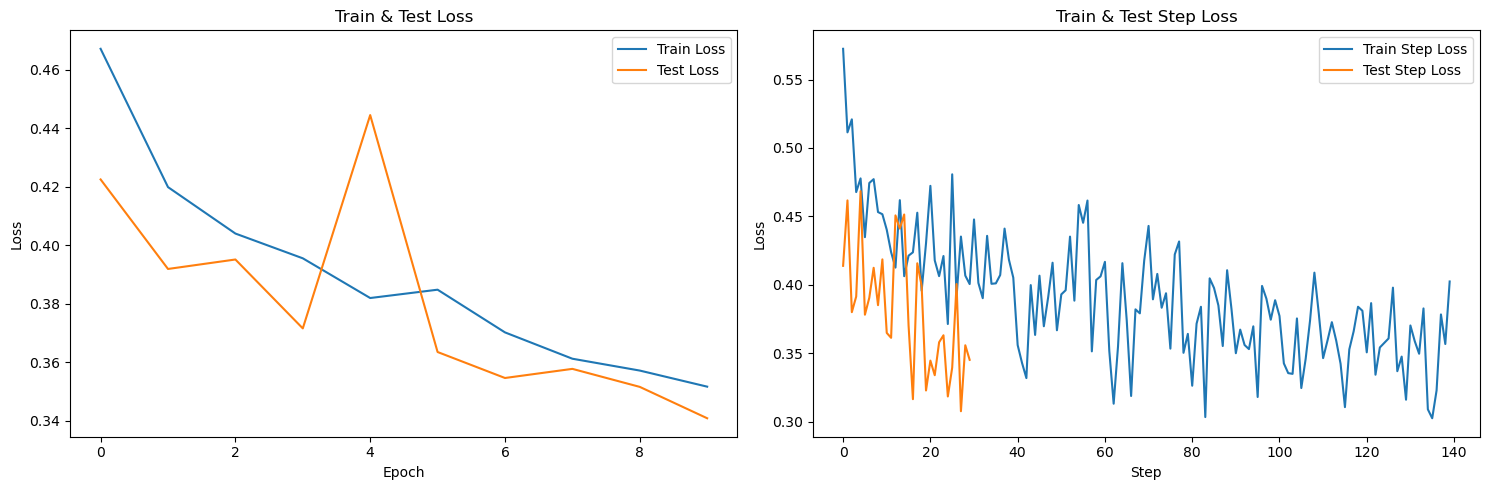

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_step_losses, label='Train Step Loss')
plt.plot(test_step_losses, label='Test Step Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Train & Test Step Loss')
plt.legend()

plt.tight_layout()
plt.show()